In [43]:
import matplotlib.pyplot as plt
import glob
import cv2
import random
from IPython.display import Image
from PIL import Image as Img
from IPython.core.display import display, HTML
import numpy as np
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
import time

display(HTML('<style>.prompt{width: 0px !important; min-width: 0px !important; visibility: collapse !important;}</style>'))

# Escalator Object Detection Using Tensorflow

# Breakdown of How Faster RCNN Works

## Feature Extraction

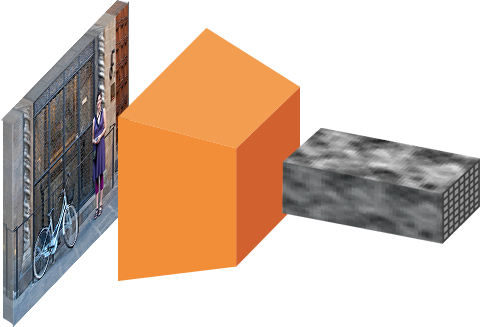

In [3]:
Image("feature_extractor.png")

- Image is preprocessed and inputted into a pretrained feature extractor (VGG-16)
- Starts by extracting low level details such as edges
- Each filter adds another layer of depth
- Subsequent layers attempt to attract patterns or high level details from image
- Relative location of features remains constant

## Anchors

In [39]:
display(HTML('<img src="anchor.png" alt="anchor" style="width: 600px;"/>'))

- A list of various sizes and ratios is defined
- Anchors can be customized to suit needs
- For each size, a bounding box for each ratio is created with the anchor as the center
  - Each color depicts a different size with the varying length to width ratios

## Region Proposal Network (RPN)

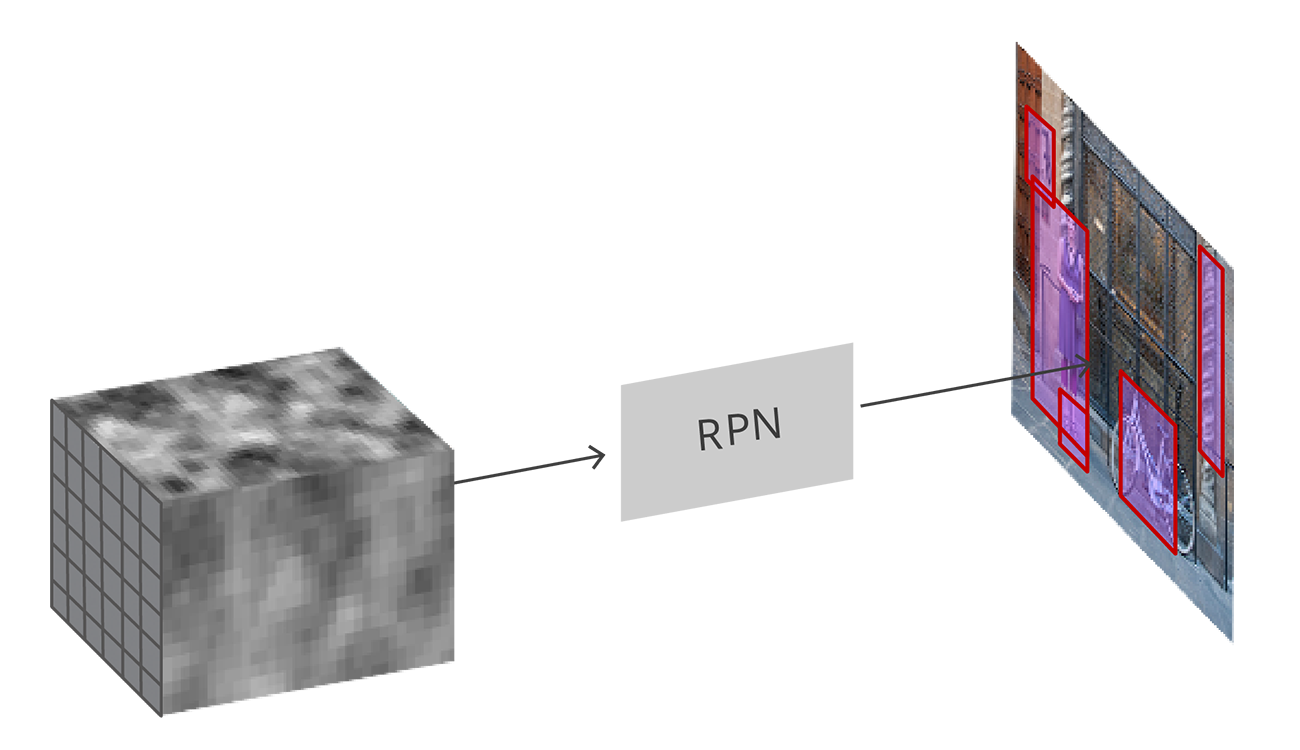

In [22]:
Image("rpn.png")

 - Convolutional Neural Networks output of a fixed shape
 - Bounding boxes for various regions of interest must be formed. However, it is impossible to know the number of outputs in advance
 - Solution: Have every anchor be evaluated by the region proposal network
   - May seem inefficient at first, but is in fact a fast and accurate solution to evaluating every region
 - The convolutional feature map is inputted and has two sets of values that are outputted; one predicts the probability that the region contains an object (background vs foreground), and the second predicts offset values to produce a more precise bounding box

## Region of Interest Pooling Layer (ROI Pooling)

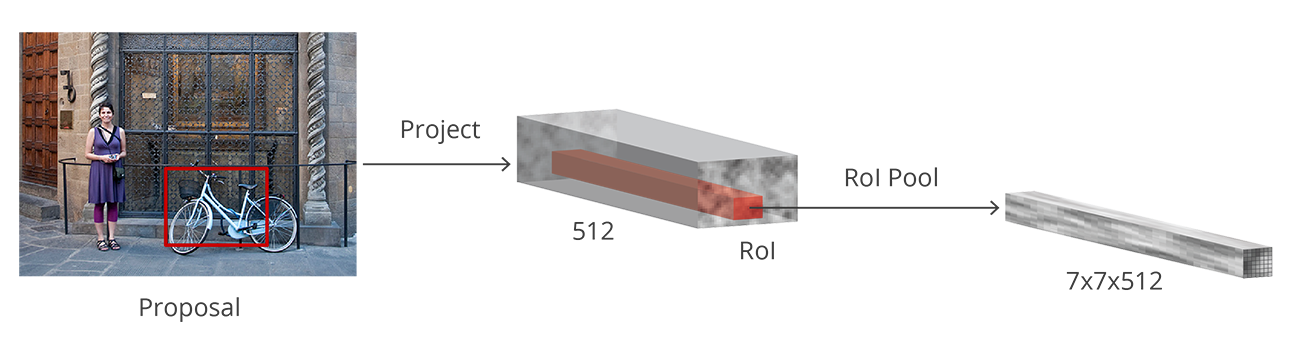

In [20]:
Image("roi_pool.png")

- Each of the proposed regions is a different size and none of the regions are assigned to their specific class (Although in this case the regions can only belong to one class which simplifies computation)
- Crops out each proposal from the convolutional feature map which was generated by VGG-16 earlier and resizes to 14x14xDepth
- A max pooling layer is then applied to each cropped section filtering out the unimportant details and standarizing the final input size to be 7x7xDepth

## Region Based Convolutional Neural Network (R-CNN)

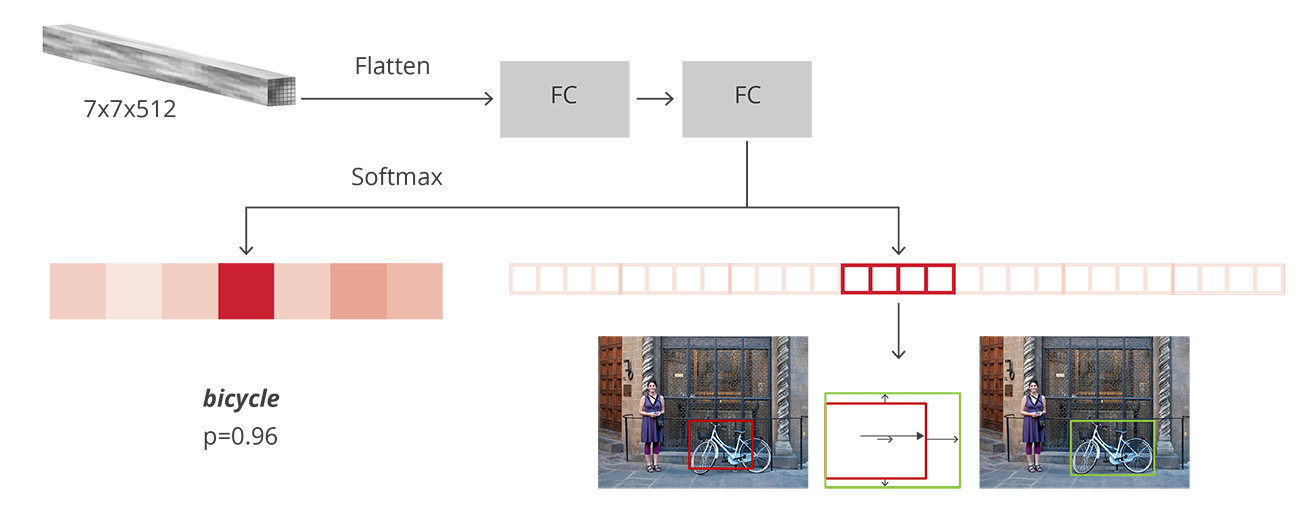

In [23]:
Image("rcnn.png")

- Final step is to classify each of the proposals
  - The R-CNN also adds an extra background class to eliminate empty bounding boxes
- Further refines the bounding boxes that were given
- The feature map for each proposal is flattened before being inputted into fully connected dense layers
- Final output is a N classes + 1 (+1 because of background), along with 4 × N modifications for each of the bounding boxes

## Complete Diagram and Summary

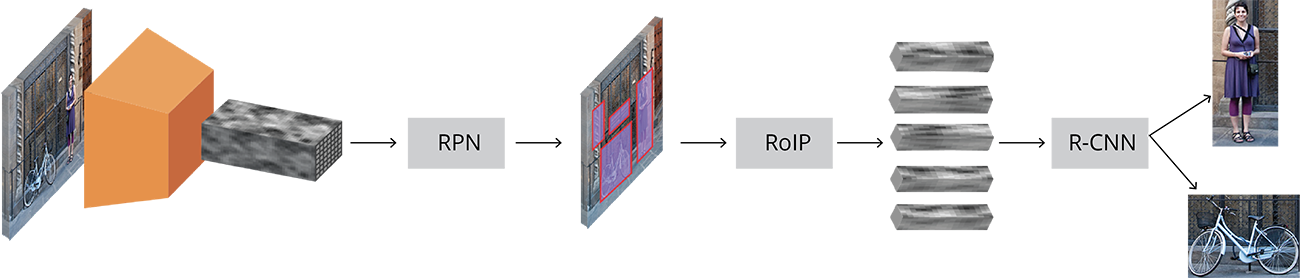

In [16]:
Image("faster_rcnn_architecture.png")

- Image is inputted into a feature extractor where a convolutional feature map is generated
- The convolutional feature map has anchors added on and is sent to a RPN
- The region proposal network comes determines if anchors are background or foreground and modifies bounding boxes
- RoIP standardizes the inputs and sends them to the R-CNN
- R-CNN outputs classification predictions and final bounding box locations

### Why Faster R-CNN?

|Model name                                              |Speed (ms)|COCO mAP|
|--------------------------------------------------------|----|--|
|ssd_mobilenet_v1_coco                                   |30  |21|
|ssd_mobilenet_v1_0.75_depth_coco                        |26  |18|
|ssd_mobilenet_v1_quantized_coco                         |29  |18|
|ssd_mobilenet_v1_0.75_depth_quantized_coco              |29  |16|
|ssd_mobilenet_v1_ppn_coco                               |26  |20|
|ssd_mobilenet_v1_fpn_coco                               |56  |32|
|ssd_resnet_50_fpn_coco                                  |76  |35|
|ssd_mobilenet_v2_coco                                   |31  |22|
|ssd_mobilenet_v2_quantized_coco                         |29  |22|
|ssdlite_mobilenet_v2_coco                               |27  |22|
|ssd_inception_v2_coco                                   |42  |24|
|faster_rcnn_inception_v2_coco                           |58  |28|
|faster_rcnn_resnet50_coco                               |89  |30|	
|faster_rcnn_resnet50_lowproposals_coco                  |64  |--|		
|rfcn_resnet101_coco	                                 |92  |30|
|faster_rcnn_resnet101_coco 	                         |106 |32|	
|faster_rcnn_resnet101_lowproposals_coco                 |82  |--|
|faster_rcnn_inception_resnet_v2_atrous_coco             |620 |37|
|faster_rcnn_inception_resnet_v2_atrous_lowproposals_coco|241 |--|
|faster_rcnn_nas                                         |1833|43|
|faster_rcnn_nas_lowproposals_coco                       |540 |--|
|mask_rcnn_inception_resnet_v2_atrous_coco               |771 |36|	
|mask_rcnn_inception_v2_coco                             |79  |25|
|mask_rcnn_resnet101_atrous_coco                         |470 |33|
|mask_rcnn_resnet50_atrous_coco                          |343 |29|


- Variety of models to choose from
- Faster R-CNN is well known, developed by Microsoft
- Strikes a balance between the speed, accuracy tradeoff

## Fine Tuning (aka Transfer Learning)

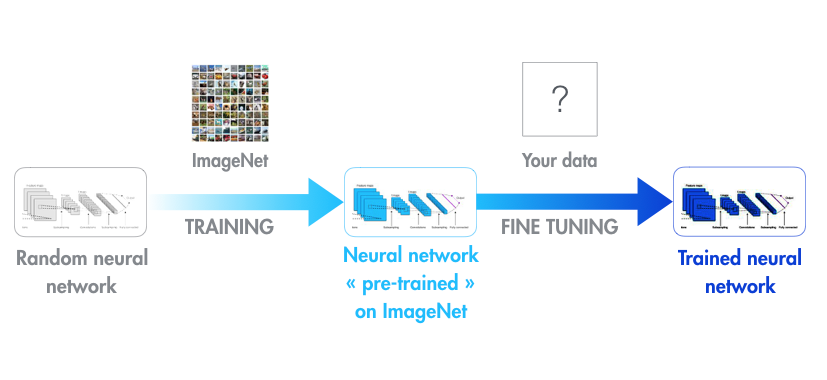

In [22]:
Image("fine_tuning.png")

- Faster R-CNN is trained on ImageNet which has 1.2 million images in 1000 categories
- The classes do not directly apply to object detection on escalators. However, as is true with humans, past knowledge can help learn new topics
- Training object detection from scratch requires an immense amount of data and computing power
- Fine tuning saves valuable time and is just as effective as training from scratch

## Gathering Input Data

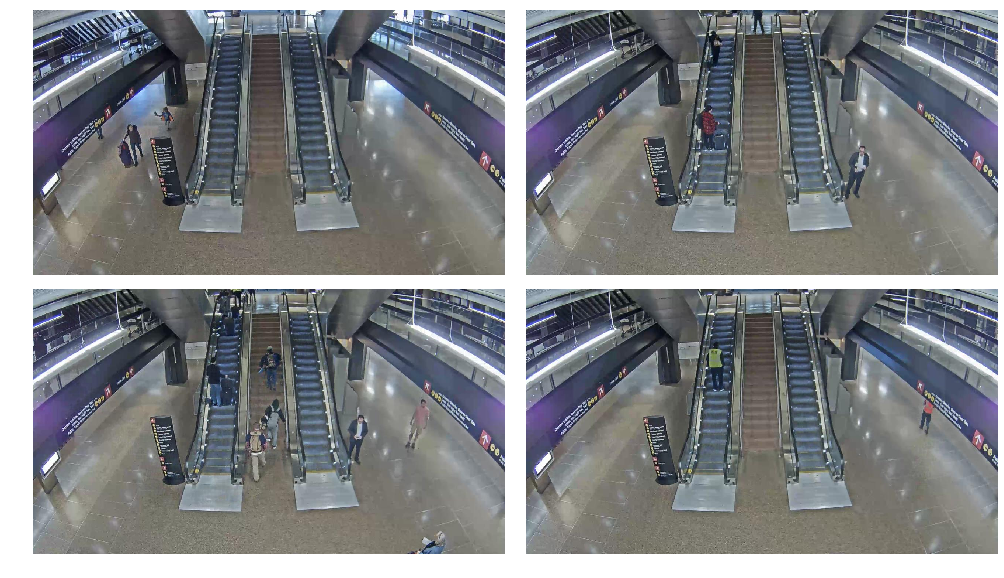

In [28]:
image_paths = glob.glob("C:/Users/aya708/Desktop/TensorFlow/workspace/escalator_object_detection/images/train/*.jpg")
fig = plt.figure(figsize=(17.5, 10))

for i in range(1, 5):
    ax1 = fig.add_subplot(2,2,i)
    ax1.imshow(Img.open(random.choice(image_paths)))
    plt.axis("off")

plt.subplots_adjust(wspace=0.02, hspace=0.05)

- Data was taken from one security camera over a period of 1-2 days
- Features a variety of situations

## Labelling Data with LabelImg

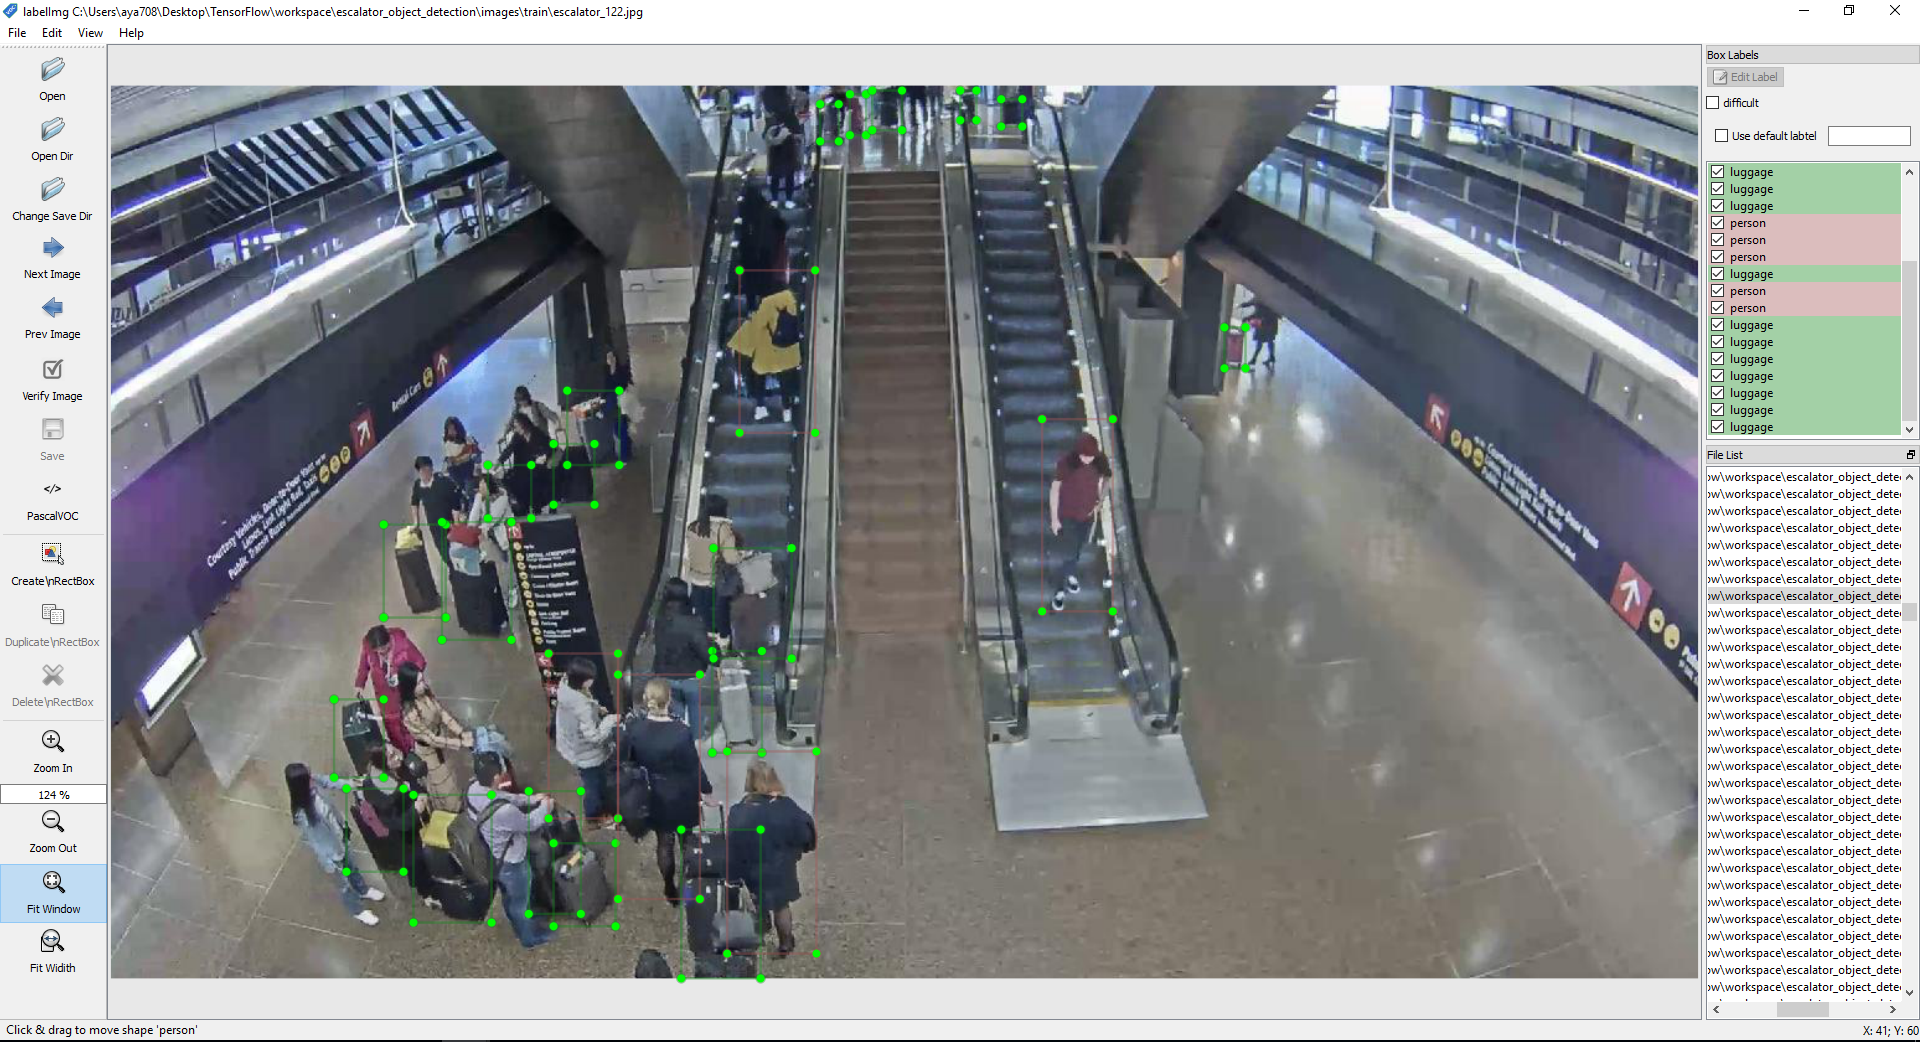

In [23]:
Image("labelimg_example.png")

- Completely open source and free to use
- Can be configured to label as many classes as needed
- Outputs an XML file which is linked to each image

## XML File

```
<annotation>
	<folder>train</folder>
	<filename>escalator_122.jpg</filename>
	<path>C:\Users\aya708\Desktop\TensorFlow\workspace\escalator_object_detection\images\train\escalator_122.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1280</width>
		<height>720</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>luggage</name>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>368</xmin>
			<ymin>246</ymin>
			<xmax>410</xmax>
			<ymax>306</ymax>
		</bndbox>
	</object>
	<object>
		<name>luggage</name>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>357</xmin>
			<ymin>289</ymin>
			<xmax>390</xmax>
			<ymax>338</ymax>
		</bndbox>
	</object>
	<object>
    ...
```

In [29]:
PATH_TO_CKPT = "C:\\Users\\aya708\\Desktop\\TensorFlow\\workspace\\" + \
               "escalator_object_detection\\trained-inference-graphs\\frozen_inference_graph.pb"
PATH_TO_LABELS = "C:\\Users\\aya708\\Desktop\\TensorFlow\\workspace\\escalator_object_detection\\" + \
                 "annotations\\label_map.pbtxt"

NUM_CLASSES = 1

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Import the object detection graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
    sess = tf.Session(graph=detection_graph)

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

In [31]:
PATH_TO_IMAGE = "C:\\Users\\aya708\\Desktop\\TensorFlow\\workspace\\" + \
    "escalator_object_detection\\images\\test\\escalator_024.jpg"

# Time how long it takes to evaluate an image
start = time.time()


image = cv2.imread(PATH_TO_IMAGE)
image_expanded = np.expand_dims(image, axis=0)

# Input image and run through the model
(boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})

# Draw bounding boxes, labels, and confidence
vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=2,
    min_score_thresh=0.5)

end = time.time()

print("Time elapsed:", str(end - start) + "s")
# Display the image
cv2.imshow('Object Detection', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


Time elapsed: 1.6893534660339355s


#### Citations

Images of Faster R-CNN Architecture taken from: https://tryolabs.com

Fine tuning diagram: http://kcail.com/